## Import Required Packages

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import PIL
import datetime
import os
import random
import shutil
import time

## Load Required File Path

In [2]:
all_file = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR'
test1_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183533/183533.svs.0.tfrecords'
test2_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183504/183504.svs.0.tfrecords'
test3_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183308/183308.svs.0.tfrecords'
test4_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183298/183298.svs.0.tfrecords'
test5_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183295/183295.svs.0.tfrecords'
test6_l0 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183293/183293.svs.0.tfrecords'

## Compute Image Features from Image Array Parsed from TF Record

In [3]:
def parse_tf(tf_path):
    feature = {'image/height': tf.io.FixedLenFeature([], tf.int64),
               'image/width': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image/name': tf.io.FixedLenFeature([], tf.string),
               'image/rescale_factor': tf.io.FixedLenFeature([], tf.int64),
               'image/encoded': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    pGAN_dataset = tfrecord_dataset.map(_parse_image_function)

    imgs = list()
    patch_name = list()
    for tfrecord_value in pGAN_dataset:
        img = tf.io.decode_image(tfrecord_value['image/encoded'])
        img = img[:, :, :3]   # trim off alpha channel
        imgs.append(img)
        img_name = tfrecord_value['image/name']
        patch_name.append(img_name)
        image_shape = img.shape

    return imgs, patch_name, image_shape

In [4]:
def customize_resnet(input_shape=(512, 512, 3)):
    ## Load the ResNet50 model
    resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet',input_shape=input_shape)
    resnet50_model.trainable = False  ## Free Training

    ## Create a new Model based on original resnet50 model ended after the 3rd residual block
    layer_name = 'conv4_block1_0_conv'
    res50 = tf.keras.Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer(layer_name).output)

    ## Add adaptive mean-spatial pooling after the new model
    adaptive_mean_spatial_layer = tf.keras.layers.GlobalAvgPool2D()
    
    return res50, adaptive_mean_spatial_layer

In [84]:
def get_img_feature(img_array, res50, adaptive_mean_spatial_layer):
    Image_Features = list()
    for i in range(len(img_array)):
        image_np = np.array(img_array[i])
        image_batch = np.expand_dims(image_np, axis=0)
        image_patch = tf.keras.applications.resnet50.preprocess_input(image_batch.copy())
        predicts = res50.predict(image_patch)
        features = adaptive_mean_spatial_layer(predicts)

        img_features = features.numpy()
        img_features = tf.convert_to_tensor(img_features)
        
        Image_Features.append(img_features)
    
    # preprocessing Image Features to match the required input shape of K Means clustering fit method
    # default shape be (#img_patches, 1024)
    Image_Features_Flat = [tf.reshape(i, (img_features.shape[1], )).numpy() for i in Image_Features]
    Image_Features_Flat = np.array(Image_Features_Flat)
    Image_Features_Flat_Transpose = np.transpose(Image_Features_Flat)
    
    return Image_Features, Image_Features_Flat, Image_Features_Flat_Transpose

In [7]:
imgs_1, patch_name_1, image_shape_1 = parse_tf(test1_l0)

In [85]:
imgs_2, patch_name_2, image_shape_2 = parse_tf(test2_l0)
imgs_3, patch_name_3, image_shape_3 = parse_tf(test3_l0)
imgs_4, patch_name_4, image_shape_4 = parse_tf(test4_l0)
imgs_5, patch_name_5, image_shape_5 = parse_tf(test5_l0)
imgs_6, patch_name_6, image_shape_6 = parse_tf(test6_l0)

In [86]:
res50, adaptive_mean_spatial_layer = customize_resnet(input_shape=image_shape_1)

In [87]:
Image_Features_1, IFF1, IFT1 = get_img_feature(img_array=imgs_1, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)

In [88]:
Image_Features_2, IFF2, IFT2 = get_img_feature(img_array=imgs_2, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_3, IFF3, IFT3 = get_img_feature(img_array=imgs_3, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_4, IFF4, IFT4 = get_img_feature(img_array=imgs_4, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_5, IFF5, IFT5 = get_img_feature(img_array=imgs_5, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_6, IFF6, IFT6 = get_img_feature(img_array=imgs_6, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)

## Plot Image Feature Distribution

In [101]:
I_feature1 = [tf.reshape(i, (image_shape_1[0], )).numpy() for i in Image_Features_1]

In [123]:
dense_fig_1 = sns.displot(I_feature1)
dense_fig_1.savefig('density Plot 1.png')

## K Means Clustering

In [10]:
def optimize_kmean(x, init_k=2, max_k=10):
    silh_score = list()
    
    for k in range(init_k, max_k+1):
        kmeans = KMeans(n_clusters=k).fit(x)
        labels = kmeans.labels_
        silh = silhouette_score(x, labels, metric='euclidean')
        silh_score.append(silh)
    
    idm_silh = silh_score.index(max(silh_score))
    optim_k = init_k + idm_silh
    
    return silh_score, optim_k

### Test1 - Find Optimized K on 6 SVS Slides at Level 0 in Image Feature Space

In [11]:
silh_score_1, optim_k_1 = optimize_kmean(x=IFF1, init_k=2, max_k=10)

In [ ]:
silh_score_2, optim_k_2 = optimize_kmean(x=IFF2, init_k=2, max_k=10)
silh_score_3, optim_k_3 = optimize_kmean(x=IFF3, init_k=2, max_k=10)
silh_score_4, optim_k_4 = optimize_kmean(x=IFF4, init_k=2, max_k=10)
silh_score_5, optim_k_5 = optimize_kmean(x=IFF5, init_k=2, max_k=10)
silh_score_6, optim_k_6 = optimize_kmean(x=IFF6, init_k=2, max_k=10)

### Test2 - PCA -> Optimizing K Inherited Test1 in Image Feature Space

In [50]:
pca = PCA(n_components=10)

In [89]:
pca_c = pca.fit(IFT1)

In [90]:
x = pca_c.components_[1]

In [91]:
y = pca_c.components_[2]

/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Anaconda/conda_env/clam/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


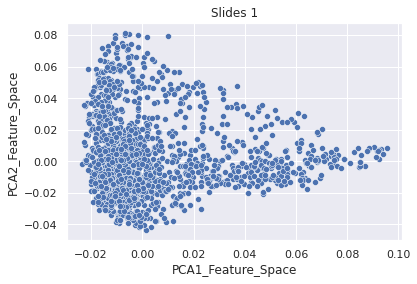

In [92]:
sns.scatterplot(x,y)
plt.title('Slides 1')
plt.xlabel('PCA1_Feature_Space')
plt.ylabel('PCA2_Feature_Space')
plt.savefig('PCA_fs_s1.png')

In [93]:
PCA_F1 = pca.fit_transform(IFT1)

In [94]:
PCA_F2 = pca.fit_transform(IFT2)
PCA_F3 = pca.fit_transform(IFT3)
PCA_F4 = pca.fit_transform(IFT4)
PCA_F5 = pca.fit_transform(IFT5)
PCA_F6 = pca.fit_transform(IFT6)

In [95]:
ss1, ok1 = optimize_kmean(x=PCA_F1, init_k=2, max_k=10)

In [96]:
ss2, ok2 = optimize_kmean(x=PCA_F2, init_k=2, max_k=10)
ss3, ok3 = optimize_kmean(x=PCA_F3, init_k=2, max_k=10)
ss4, ok4 = optimize_kmean(x=PCA_F4, init_k=2, max_k=10)
ss5, ok5 = optimize_kmean(x=PCA_F5, init_k=2, max_k=10)
ss6, ok6 = optimize_kmean(x=PCA_F6, init_k=2, max_k=10)

### Test3 - Optimizing K on 6 SVS Slides at Level 5 (i.e. 32 x 32) in Image Patch Space

In [19]:
test1_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183533/183533.svs.5.tfrecords'
test2_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183504/183504.svs.5.tfrecords'
test3_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183308/183308.svs.5.tfrecords'
test4_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183298/183298.svs.5.tfrecords'
test5_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183295/183295.svs.5.tfrecords'
test6_l5 = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Google_svs/Normal_skin_TFRECORDS/TF_DIR/183293/183293.svs.5.tfrecords'

In [21]:
imgs1, patch_name1, image_shape1 = parse_tf(test1_l5)

In [ ]:
imgs2, patch_name2, image_shape2 = parse_tf(test2_l5)
imgs3, patch_name3, image_shape3 = parse_tf(test3_l5)
imgs4, patch_name4, image_shape4 = parse_tf(test4_l5)
imgs5, patch_name5, image_shape5 = parse_tf(test5_l5)
imgs6, patch_name6, image_shape6 = parse_tf(test6_l5)

In [22]:
new_shape = np.prod(imgs1[0].shape)

In [23]:
def img_reshape(imgs, new_shape):
    imgs = [tf.reshape(i, (new_shape, )).numpy() for i in imgs]
    imgs = np.array(imgs)
    
    return imgs

In [24]:
imgs1 = img_reshape(imgs1, new_shape)

In [ ]:
imgs2 = img_reshape(imgs2, new_shape)
imgs3 = img_reshape(imgs3, new_shape)
imgs4 = img_reshape(imgs4, new_shape)
imgs5 = img_reshape(imgs5, new_shape)
imgs6 = img_reshape(imgs6, new_shape)

In [25]:
pca_p = PCA(n_components=10)

In [58]:
imgs11 = np.transpose(imgs1)   ## transpose of image features

In [41]:
pca_pc = pca_p.fit(imgs11)

In [59]:
x = pca_pc.components_[0]
y = pca_pc.components_[1]

/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Anaconda/conda_env/clam/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


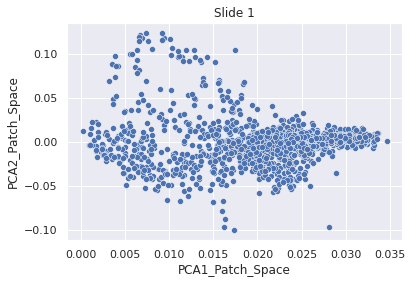

In [43]:
sns.scatterplot(x,y)
plt.title('Slide 1')
plt.xlabel('PCA1_Patch_Space')
plt.ylabel('PCA2_Patch_Space')
plt.savefig('PCA_ps_s1.png')

In [123]:
silh_score_51, optim_k_51 = optimize_kmean(x=imgs11, init_k=2, max_k=50)
optim_k_51

2

In [122]:
silh_score_51

[0.31823239127270014,
 0.24554395621860992,
 0.22597891391651945,
 0.18834284465629225,
 0.07939665736536884,
 0.08611952318302148,
 0.09227784073910805,
 0.09578251478845218,
 0.08227689650218005]

In [ ]:
silh_score_52, optim_k_52 = optimize_kmean(x=imgs2, init_k=2, max_k=10)
silh_score_53, optim_k_53 = optimize_kmean(x=imgs3, init_k=2, max_k=10)
silh_score_54, optim_k_54 = optimize_kmean(x=imgs4, init_k=2, max_k=10)
silh_score_55, optim_k_55 = optimize_kmean(x=imgs5, init_k=2, max_k=10)
silh_score_56, optim_k_56 = optimize_kmean(x=imgs6, init_k=2, max_k=10)

In [30]:
def ok_clustering(x, optim_k):
    kmean_labels = list()
    kmeans = KMeans(n_clusters=optim_k).fit(x)
    
    for i in kmeans.labels_:
        kmean_labels.append(i)
    
    return kmean_labels

In [31]:
kmean_labels = ok_clustering(x=IFF1, optim_k=optim_k_51)

## Test 4 - Force K=50 for clustering with Image Features in Original Shape

In [65]:
kmeans_fs50 = KMeans(n_clusters=50)
kmeans_fs50.fit(IFF1)

KMeans(n_clusters=50)

In [104]:
patch_id_1o = list()
for i in range(len(IFF1)):
    patch_id_1o.append(i)

In [115]:
patch_names_1o = [i.numpy().decode('utf-8') for i in patch_name_1]

In [116]:
cluster_id_1o = list()
for i in kmeans_fs50.labels_:
    cluster_ido_1.append(i)

In [117]:
df_50_1o = pd.DataFrame(list(zip(patch_id_1o, patch_names_1o, cluster_id_1o)),
              columns=['patch_id', 'patch_name', 'cluster_id'])

In [118]:
df_50_1o

,patch_id,patch_name,cluster_id
0,0,183533.svs_x_1024_2048_y_5120_6144.png,25
1,1,183533.svs_x_1024_2048_y_6144_7168.png,2
2,2,183533.svs_x_1024_2048_y_9216_10240.png,2
3,3,183533.svs_x_1024_2048_y_10240_11264.png,25
4,4,183533.svs_x_14336_15360_y_10240_11264.png,5
...,...,...,...
1871,1871,183533.svs_x_154624_155648_y_44032_45056.png,46
1872,1872,183533.svs_x_154624_155648_y_45056_46080.png,34
1873,1873,183533.svs_x_154624_155648_y_46080_47104.png,46
1874,1874,183533.svs_x_154624_155648_y_47104_48128.png,7


In [119]:
df_50_1o.to_csv('k_50_1O_clustering.txt', sep='\t', index=False)

In [181]:
patch_path = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Clustering/images'

In [182]:
dest_path = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/pGAN_CO'

In [204]:
def clustering_check_o(patch_path, dest_path):
    for i in range(50):
        for j in df_50_1o['cluster_id']:
            if j == i:
                for k in pd.DataFrame(df_50_1o['patch_id'][df_50_1o['cluster_id'] == j])['patch_id']:
                    name = os.listdir(patch_path)[k]
                    file = os.path.join(patch_path, name)
                    dest_dir = os.path.join(dest_path, 'Cluster_Origin_Shape_' + str(j))
                    if os.path.exists(dest_dir) == False:
                        os.mkdir(os.path.join(dest_path, 'Cluster_Origin_Shape_' + str(j)))
                    shutil.copy(file, dest_dir)

In [205]:
clustering_check_o(patch_path=patch_path, dest_path=dest_path)df_50_1t

## Test 5 - Force K=50 for Clustering in Feature Space with Transposed Image Features 

In [60]:
kmeans_fst50 = KMeans(n_clusters=50)

In [64]:
kmeans_fst50.fit(IFT1)

KMeans(n_clusters=50)

In [111]:
IFeature_1 = list()
for i in IFF1:
    IFeature_1.append(i)

In [112]:
Ifeature_T1 = list()
for i in IFT1:
    Ifeature_T1.append(i)

In [68]:
patch_id_1t = list()
for i in range(len(IFT1)):
    patch_id_1t.append(i)

In [69]:
patch_names_1t = [i.numpy().decode('utf-8') for i in patch_name_1]

In [70]:
cluster_id_1t = list()
for i in kmeans_fst50.labels_:
    cluster_id_1t.append(i)

In [113]:
df_50_1t = pd.DataFrame(list(zip(patch_id_1t, patch_names_1t, cluster_id_1t, IFeature_1, Ifeature_T1)),
              columns=['patch_id', 'patch_name', 'cluster_id', 'ifeature', 'ifeature_t'])

In [114]:
df_50_1t

,patch_id,patch_name,cluster_id,ifeature,ifeature_t
0,0,183533.svs_x_1024_2048_y_5120_6144.png,0,"[-0.7375171, -0.5608418, 0.28726444, -0.393612...","[-0.7375171, -0.97203934, -1.0615458, -0.84118..."
1,1,183533.svs_x_1024_2048_y_6144_7168.png,25,"[-0.97203934, -0.3210382, 0.3491544, -0.253294...","[-0.5608418, -0.3210382, -0.26693258, -0.37339..."
2,2,183533.svs_x_1024_2048_y_9216_10240.png,19,"[-1.0615458, -0.26693258, 0.37291557, -0.23579...","[0.28726444, 0.3491544, 0.37291557, 0.3244394,..."
3,3,183533.svs_x_1024_2048_y_10240_11264.png,30,"[-0.84118974, -0.3733927, 0.3244394, -0.311691...","[-0.3936123, -0.25329423, -0.23579088, -0.3116..."
4,4,183533.svs_x_14336_15360_y_10240_11264.png,24,"[-0.6300889, -0.5949823, 0.5162739, -0.2353520...","[-0.15682802, -0.07299091, -0.04575931, -0.120..."
...,...,...,...,...,...
1019,1019,183533.svs_x_102400_103424_y_37888_38912.png,43,"[-0.2629743, -0.94696885, 0.377868, -0.5436137...","[-0.31877652, -0.10219216, -0.16573742, -0.262..."
1020,1020,183533.svs_x_102400_103424_y_38912_39936.png,13,"[-0.34527197, -0.9301513, 0.3605195, -0.545523...","[0.2999874, 0.023410333, -0.013596621, 0.15225..."
1021,1021,183533.svs_x_102400_103424_y_39936_40960.png,35,"[-0.2852913, -0.92036265, 0.37121478, -0.52886...","[-0.66443306, -0.81252396, -0.864245, -0.78307..."
1022,1022,183533.svs_x_102400_103424_y_40960_41984.png,17,"[-0.47826105, -0.8258475, 0.31796038, -0.50917...","[0.2818304, 0.3206338, 0.3535965, 0.2945345, 0..."


In [115]:
df_50_1t.to_csv('k_50_1T_clustering.txt', sep='\t', index=False)

In [77]:
patch_path = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Clustering/images'
dest_path = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/pGAN_CT'

In [78]:
def clustering_check_t(patch_path, dest_path):
    for i in range(50):
        for j in df_50_1t['cluster_id']:
            if j == i:
                for k in pd.DataFrame(df_50_1t['patch_id'][df_50_1t['cluster_id'] == j])['patch_id']:
                    name = os.listdir(patch_path)[k]
                    file = os.path.join(patch_path, name)
                    dest_dir = os.path.join(dest_path, 'Cluster_Transposed_' + str(j))
                    if os.path.exists(dest_dir) == False:
                        os.mkdir(os.path.join(dest_path, 'Cluster_Transposed_' + str(j)))
                    shutil.copy(file, dest_dir)

In [79]:
clustering_check_t(patch_path=patch_path, dest_path=dest_path)

## Test 6 Finding Optimized K in Feature Space with Transposed Image Features

In [80]:
def optim_k_tfs(x, init_k=2, max_k=10):
    silh_score = list()
    
    for k in range(init_k, max_k+1):
        kmeans = KMeans(n_clusters=k).fit(x)
        labels = kmeans.labels_
        silh = silhouette_score(x, labels, metric='euclidean')
        #print(k, '\t', silh)
        silh_score.append(silh)
    
    idm_silh = silh_score.index(max(silh_score))
    optim_k = init_k + idm_silh
    
    return silh_score, optim_k

In [81]:
silh_score_tfs_1, optim_k_tfs_1 = optim_k_tfs(x=IFT1, init_k=2, max_k=10)

## Test 7 - Select Patches based on Top K PCA1 & PCA2 Values

In [127]:
pca_t7 = PCA(n_components=10)

In [159]:
pca_t7_1 = pca_t7.fit(IFT1).components_[0]
pca_t7_2 = pca_t7.fit(IFT1).components_[1]
pca_t7_3 = pca_t7.fit(IFT1).components_[2]
pca_t7_4 = pca_t7.fit(IFT1).components_[3]

In [141]:
top_pca1_index = pca_t7_1.argsort()[-50:][::-1]
top_pca2_index = pca_t7_2.argsort()[-50:][::-1]

In [134]:
top_pca1 = list()
for i in top_pca1_index:
    top_pca1.append(pca_t7_1[i])

In [142]:
top_pca2 = list()
for i in top_pca2_index:
    top_pca1.append(pca_t7_2[i])

In [155]:
def patch_select_pca(patch_path, dest_path, n_pca_comp, pca_index):
    dest_dir = os.path.join(dest_path, 'Top50_PCA_' + str(n_pca_comp))
    if os.path.exists(dest_dir) == False:
        os.mkdir(os.path.join(dest_path, 'Top50_PCA_' + str(n_pca_comp)))
    for i in top_pca1_index:
        name = os.listdir(patch_path)[i]
        file = os.path.join(patch_path, name)
        shutil.copy(file, dest_dir)

In [157]:
patch_path = '/research/bsi/projects/PI/tertiary/Sun_Zhifu_zxs01/s4331393.GTEX/processing/naresh/Digital_path/Clustering/images'
dest_path = '/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Data/pGAN_PCA'

In [158]:
patch_select_pca(patch_path=patch_path, dest_path=dest_path, n_pca_comp=1, pca_index=top_pca1_index)
patch_select_pca(patch_path=patch_path, dest_path=dest_path, n_pca_comp=2, pca_index=top_pca2_index)

## Test 8 - Normalized PCA Values and applied them to replace Alpha Channel of Image Patches

In [187]:
def norm_pca(smin, smax, pca_val):
    norm_pca = list()
    for i in pca_val:
        norm_val = (i - min(pca_val)) * (smax - smin) / (max(pca_val) - min(pca_val)) + smin
        norm_val_int = int(norm_val)
        norm_pca.append(norm_val_int)
        
    return norm_pca

In [ ]:
norm_pca1 = norm_pca(smin=0, smax=255, pca_val=pca_t7_1)
norm_pca2 = norm_pca(smin=0, smax=255, pca_val=pca_t7_2)
norm_pca3 = norm_pca(smin=0, smax=255, pca_val=pca_t7_3)
norm_pca4 = norm_pca(smin=0, smax=255, pca_val=pca_t7_4)

In [ ]:
patch_id_1_norm = list()
for i in range(len(IFF1)):
    patch_id_1_norm.append(i)

In [ ]:
df_norm_pca = pd.DataFrame(list(zip(patch_id_1_norm, norm_pca1, norm_pca2, norm_pca3, norm_pca4)),
                          columns=['Patch_ID', 'Norm_PCA_1', 'Norm_PCA_2', 'Norm_PCA_3', 'Norm_PCA_4'])

In [ ]:
df_norm_pca.to_csv('normalized_pca.txt', sep='\t', index=False)